In [1]:
import numpy as np

from scipy.fft import fftshift, ifftshift, ifftn, fftfreq
from scipy.interpolate import RegularGridInterpolator

import matplotlib.pyplot as plt

from paiskintonetools import setup_matplotlib

from patato.recon.fourier_transform_rec import FFTReconstruction

setup_matplotlib(dpi=200)

Load in the array data.

In [2]:
blood_vessel = 0  # None#-3

file_name = "" if blood_vessel is None else f"_bv1E{blood_vessel}"

subtract_homog = False

In [3]:
linear_ts = np.load(f"intermediate_results/arc_inhomog{file_name}.npy").T

if subtract_homog:
    linear_ts -= np.load("intermediate_results/arc_homog.npy").T
linear_ts = linear_ts[::-1]
fs = 4e7
c = 1540

arc_geom = np.load("arc_detector.npy").T[::-1]

arc_geom.shape

FileNotFoundError: [Errno 2] No such file or directory: 'intermediate_results/arc_inhomog_bv1E0.npy'

In [143]:
# Linear array FT reconstruction

dx_recon = 100e-6
nx_recon = 400

# Bit larger than the US reconstruction grid below to avoid aliasing
ftr = FFTReconstruction(field_of_view=(0.055, 0.055, 0), n_pixels=(550, 550, 1))
ftr.hankels = None
image, linear_ft, komega = ftr._reconstruct(
    linear_ts,
    fs=fs,
    geometry=arc_geom,
    n_pixels=ftr.n_pixels,
    field_of_view=ftr.field_of_view,
    speed_of_sound=c,
    return_ft=True,
)  # komega is k, but in inverse time radians per seconds

k = fftshift(fftfreq(linear_ft.shape[0], dx_recon))
# k = komega/ 2 * np.pi # Not angular coords
# k /= c

Interpolate the data onto the reconstruction grid.

In [144]:
# Interpolate onto kx, ky
kx_rec = fftshift(fftfreq(nx_recon * 2, dx_recon))
ky_rec = fftshift(fftfreq(nx_recon * 4, dx_recon))
KX_REC, KY_REC = np.meshgrid(kx_rec, ky_rec)
OMEGA = np.sqrt(KX_REC**2 + KY_REC**2) * c

In [145]:
interp = RegularGridInterpolator((k, k), linear_ft, bounds_error=False, fill_value=0)
recon_ft = interp((KX_REC, KY_REC))

# y_array = 0.0232
# recon_ft *= np.exp(-1j * 2*np.pi * KY_REC * y_array)

y_skin = 0.005
# recon_ft *= np.exp(1j * 2*np.pi * KY_REC * y_skin)

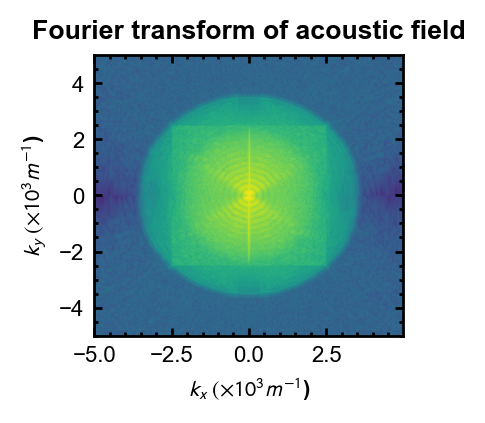

In [146]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(
    np.log(np.abs(recon_ft)),
    extent=[
        np.min(kx_rec) / 1e3,
        np.max(kx_rec) / 1e3,
        np.min(ky_rec) / 1e3,
        np.max(ky_rec) / 1e3,
    ],
    aspect="auto",
    origin="lower",
)
ax.set_xlabel(r"$k_x~(\times 10^3 m^{-1}$)")
ax.set_ylabel(r"$k_y~(\times 10^3 m^{-1}$)")
ax.set_title("Fourier transform of acoustic field")
plt.show()

[-0.02, 0.02, -0.02, 0.02]


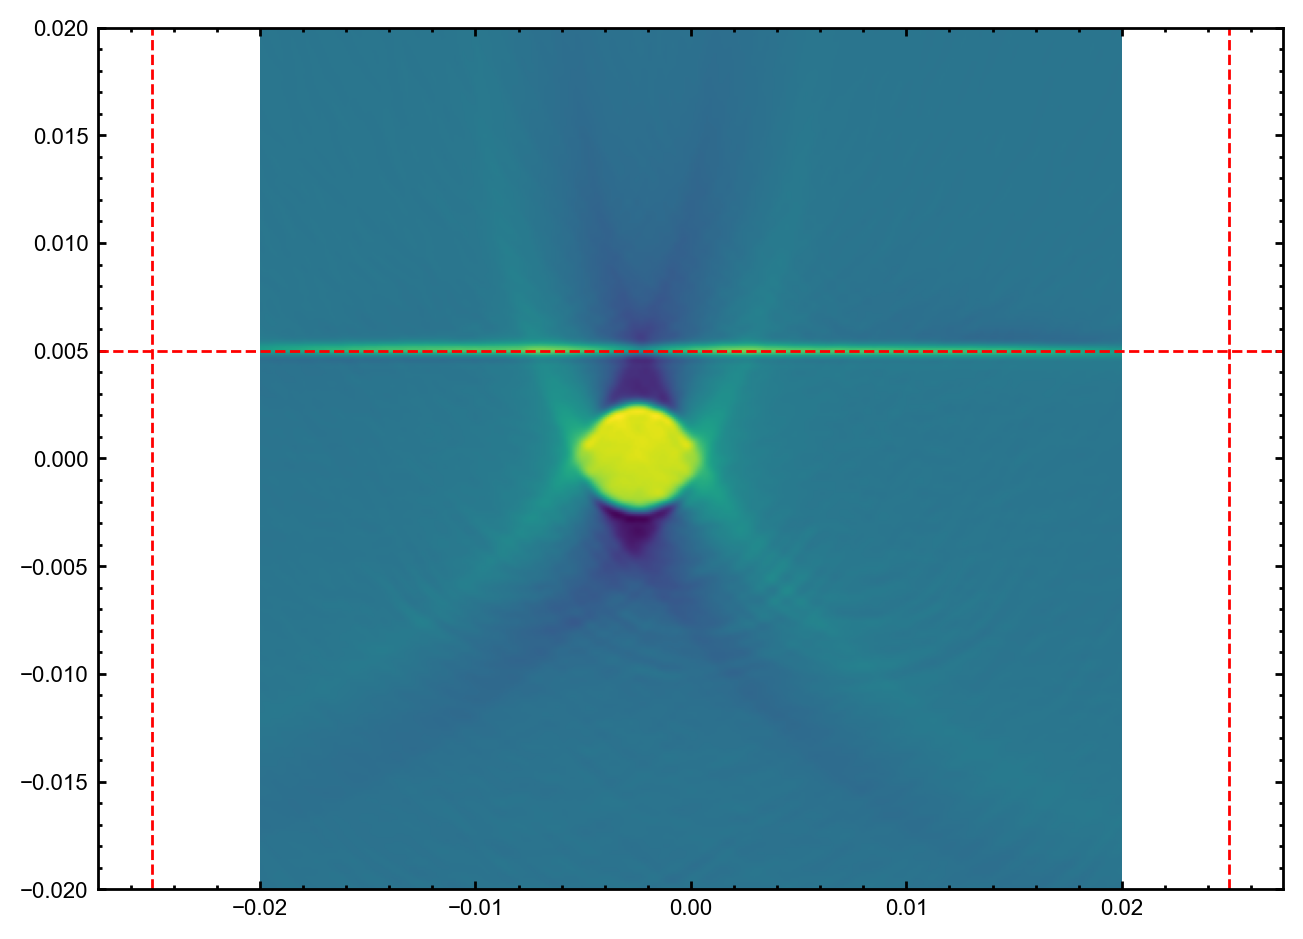

In [147]:
image = fftshift(ifftn(ifftshift(recon_ft)).real)
ic = image.shape[0] // 2
image = image[ic - 200 : ic + 200]


if not subtract_homog:
    ic = image.shape[1] // 2
    image = image[:, ic - 200 : ic + 200]
    np.save(f"output_images/pa_arc{file_name}.npy", image)

extent = [
    dx_recon * image.shape[1 - i] / 2 * sign for i in range(2) for sign in [-1, 1]
]
print(extent)
plt.imshow(image, origin="lower", extent=extent)
plt.axvline(0.025, color="red", linestyle="--")
plt.axhline(0.005, color="red", linestyle="--")
plt.axvline(-0.025, color="red", linestyle="--")
plt.show()

In [148]:
# Interpolate ft_recon onto the US dispersion relation.

KY_UNPRIMED = (KY_REC**2 - KX_REC**2) / (2 * KY_REC)

interp = RegularGridInterpolator(
    (ky_rec, kx_rec),
    recon_ft * np.exp(1j * 2 * np.pi * KY_REC * y_skin),
    bounds_error=False,
    fill_value=0,
)
recon_us_ft = interp((KY_UNPRIMED, KX_REC))

recon_us_ft[np.isnan(recon_us_ft)] = 0
recon_us_ft[~np.isfinite(recon_us_ft)] = 0

recon_us_ft *= np.exp(-1j * 2 * np.pi * KY_REC * y_skin)
# recon_us_ft *= np.exp(+2j * 2*np.pi * KY_REC * y_array)

recon_us_ft[ky_rec < 0] = 0
recon_us_ft[np.abs(KX_REC) > np.abs(KY_REC)] = 0

/tmp/ipykernel_481971/2951431569.py:3: RuntimeWarning: divide by zero encountered in divide
  KY_UNPRIMED = (KY_REC**2 - KX_REC**2) / (2 * KY_REC)
/tmp/ipykernel_481971/2951431569.py:3: RuntimeWarning: invalid value encountered in divide
  KY_UNPRIMED = (KY_REC**2 - KX_REC**2) / (2 * KY_REC)


/tmp/ipykernel_481971/1060586570.py:2: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(np.abs(recon_us_ft)),


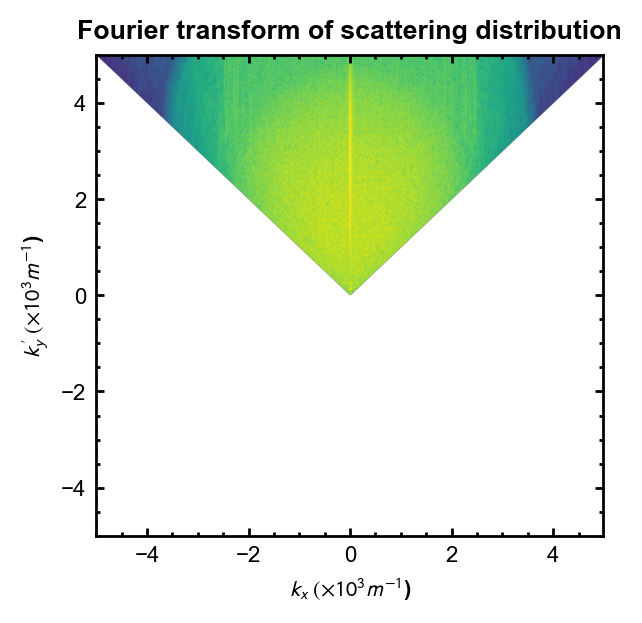

In [109]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(
    np.log(np.abs(recon_us_ft)),
    extent=[
        np.min(kx_rec) / 1e3,
        np.max(kx_rec) / 1e3,
        np.min(ky_rec) / 1e3,
        np.max(ky_rec) / 1e3,
    ],
    aspect="auto",
    origin="lower",
)
# plt.plot(np.sqrt(test)/1e3, ky_rec/1e3)
ax.set_xlabel(r"$k_x~(\times 10^3 m^{-1}$)")
ax.set_ylabel(r"$k_y^\prime~(\times 10^3 m^{-1}$)")
ax.set_title("Fourier transform of scattering distribution")
plt.show()

[-0.02, 0.02, -0.02, 0.02]


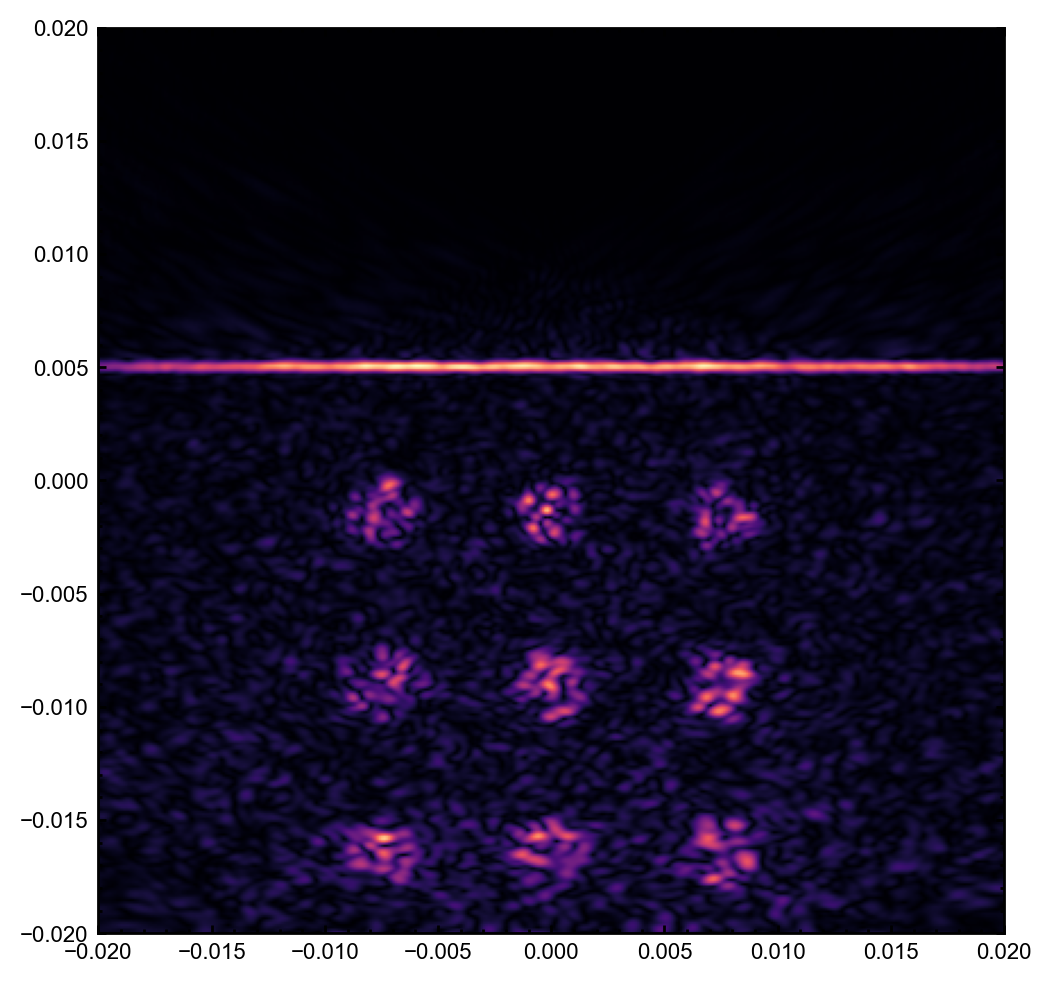

In [110]:
image = np.abs(fftshift(ifftn(ifftshift(recon_us_ft))))
# image = image[:2*nx_recon]
# image = image[200:600, 200:600]
# image = hilbert(image.real, axis=0)
image = np.abs(image)
ic = image.shape[0] // 2
image = image[ic - 200 : ic + 200]
ic = image.shape[1] // 2
image = image[:, ic - 200 : ic + 200]
image *= np.exp(-np.arange(400) / 150)[:, None]
image = np.log10(1 + 3 * image) / np.log10(4)


extent = [
    dx_recon * image.shape[1 - i] / 2 * sign for i in range(2) for sign in [-1, 1]
]
print(extent)
plt.imshow(image, origin="lower", extent=extent, cmap="magma")
plt.show()
if subtract_homog:
    np.save(f"output_images/mus_arc{file_name}.npy", image)